In [1]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})
plt.rcParams.update({"axes.axisbelow": True})
import matplotlib.ticker as mtick

In [2]:
all_citations_df = pd.read_parquet(
    "../../data/intermediate/citation_analysis/integrated_citations.parquet"
)
news_citations_df = pd.read_parquet(
    "../../data/intermediate/citation_analysis/news_citations.parquet"
)

In [3]:
all_citations_df.model_family.value_counts()

model_family
perplexity    257658
gemini         68392
gpt            40037
Name: count, dtype: int64

In [4]:
len(all_citations_df)

366087

In [5]:
len(news_citations_df)

32865

In [6]:
all_citations_df.columns

Index(['citation_id', 'response_id', 'citation_number', 'url', 'domain_full',
       'domain', 'url_valid', 'citation_order', 'political_leaning_score',
       'political_leaning', 'domain_quality_score', 'domain_quality',
       'domain_classification', 'question_id', 'thread_id', 'turn_number',
       'model_name_llm', 'model_name_raw', 'model_side', 'citation_format',
       'winner', 'primary_intent', 'secondary_intent', 'total_turns',
       'timestamp', 'model_won', 'model_lost', 'model_tied', 'model_family'],
      dtype='object')

In [7]:
# Create model name mapping for cleaner display
def get_model_provider(model_name):
    """Extract provider from model name."""
    if model_name.startswith("gpt-"):
        return "gpt"
    elif model_name.startswith("sonar"):
        return "perplexity"
    elif model_name.startswith("gemini"):
        return "gemini"
    else:
        return "Unknown"

In [8]:
# Calculate news citation percentages by model
model_stats = []

# Get unique models
models = all_citations_df["model_name_raw"].unique()

for model in models:
    # Total citations for this model
    total_citations = len(all_citations_df[all_citations_df["model_name_raw"] == model])
    model_provider = get_model_provider(model)

    # News citations for this model
    news_citations = len(
        all_citations_df[
            (all_citations_df["model_name_raw"] == model)
            & (all_citations_df["domain_classification"] == "news")
        ]
    )

    # Calculate percentage
    news_percentage = (
        (news_citations / total_citations * 100) if total_citations > 0 else 0
    )

    model_stats.append(
        {
            "model_family": model_provider,
            "model": model,
            "total_citations": total_citations,
            "news_citations": news_citations,
            "news_percentage": news_percentage,
        }
    )

# Convert to DataFrame and sort by news percentage
model_stats_df = pd.DataFrame(model_stats)
model_stats_df = model_stats_df.sort_values("news_percentage", ascending=True)

print("News citation percentages by model:")
for _, row in model_stats_df.iterrows():
    print(
        f"{row['model']}: {row['news_citations']:,}/{row['total_citations']:,} ({row['news_percentage']:.1f}%)"
    )

model_stats_df.sort_values(by=["model_family", "news_percentage"], inplace=True)
model_stats_df = pd.concat(
    [
        model_stats_df.query("model_family == 'perplexity'"),
        model_stats_df.query("model_family == 'gemini'"),
        model_stats_df.query("model_family == 'gpt'"),
    ]
)
model_stats_df

News citation percentages by model:
gemini-2.5-flash-preview-04-17-grounding: 1,583/23,886 (6.6%)
sonar-pro: 2,602/37,016 (7.0%)
sonar-pro-high: 5,167/72,644 (7.1%)
sonar: 2,794/38,266 (7.3%)
sonar-reasoning: 3,601/47,497 (7.6%)
gemini-2.0-flash-grounding: 1,324/17,060 (7.8%)
gemini-2.5-pro-exp-03-25-grounding: 2,489/27,446 (9.1%)
sonar-reasoning-pro-high: 5,662/62,235 (9.1%)
gpt-4o-search-preview-high: 1,996/10,782 (18.5%)
gpt-4o-search-preview-high-loc: 2,288/12,354 (18.5%)
gpt-4o-mini-search-preview: 1,374/7,126 (19.3%)
gpt-4o-search-preview: 1,985/9,775 (20.3%)


,model_family,model,total_citations,news_citations,news_percentage
3,perplexity,sonar-pro,37016,2602,7.029393
6,perplexity,sonar-pro-high,72644,5167,7.112769
0,perplexity,sonar,38266,2794,7.301521
1,perplexity,sonar-reasoning,47497,3601,7.581531
10,perplexity,sonar-reasoning-pro-high,62235,5662,9.097775
11,gemini,gemini-2.5-flash-preview-04-17-grounding,23886,1583,6.627313
8,gemini,gemini-2.0-flash-grounding,17060,1324,7.760844
9,gemini,gemini-2.5-pro-exp-03-25-grounding,27446,2489,9.068717
5,gpt,gpt-4o-search-preview-high,10782,1996,18.512335
7,gpt,gpt-4o-search-preview-high-loc,12354,2288,18.520317


In [9]:
# Calculate news citation percentages by model family (provider)
family_stats = []

# Get unique providers
providers = all_citations_df["model_family"].unique()

for provider in providers:
    # Get all citations from models of this provider
    provider_citations = all_citations_df[all_citations_df["model_family"] == provider]

    # Total citations for this provider
    total_citations = len(provider_citations)

    # News citations for this provider
    news_citations = len(
        provider_citations[provider_citations["domain_classification"] == "news"]
    )

    # Calculate percentage
    news_percentage = (
        (news_citations / total_citations * 100) if total_citations > 0 else 0
    )

    family_stats.append(
        {
            "provider": provider,
            "total_citations": total_citations,
            "news_citations": news_citations,
            "news_percentage": news_percentage,
        }
    )

# Convert to DataFrame and sort by news percentage
family_stats_df = pd.DataFrame(family_stats)
family_stats_df = family_stats_df.sort_values("news_percentage", ascending=True)

print("News citation percentages by model family:")
for _, row in family_stats_df.iterrows():
    print(
        f"{row['provider']}: {row['news_citations']:,}/{row['total_citations']:,} ({row['news_percentage']:.1f}%)"
    )

family_stats_df

News citation percentages by model family:
perplexity: 19,826/257,658 (7.7%)
gemini: 5,396/68,392 (7.9%)
gpt: 7,643/40,037 (19.1%)


,provider,total_citations,news_citations,news_percentage
0,perplexity,257658,19826,7.694696
2,gemini,68392,5396,7.889812
1,gpt,40037,7643,19.089842


In [10]:
# Create color mapping by provider
provider_colors = {
    "gpt": "#2E3440",
    "gemini": "#B66A97",
    "perplexity": "#20808D",
}

provider_names = {
    "gpt": "OpenAI",
    "perplexity": "Perplexity",
    "gemini": "Google",
}

In [11]:
family_stats_df

,provider,total_citations,news_citations,news_percentage
0,perplexity,257658,19826,7.694696
2,gemini,68392,5396,7.889812
1,gpt,40037,7643,19.089842


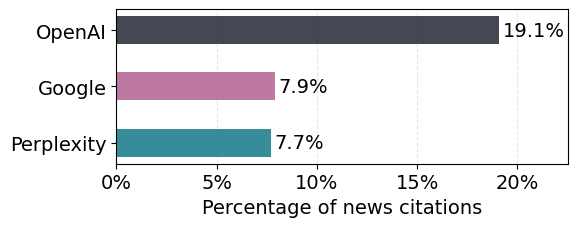

In [12]:
# Create horizontal bar plot for news citation percentages by model family
fig, ax = plt.subplots(figsize=(6, 2.5))

# Use the same color mapping as before for consistency
colors = [provider_colors[provider] for provider in family_stats_df["provider"]]

# Create horizontal bar plot
bars = ax.barh(
    range(len(family_stats_df)),
    family_stats_df["news_percentage"],
    color=colors,
    height=0.5,
    alpha=0.9,
)

# Customize the plot
ax.set_xlabel("Percentage of news citations")
# ax.set_ylabel('Model Family', fontsize=14)

# Set y-axis labels
ax.set_yticks(range(len(family_stats_df)))
ax.set_yticklabels(provider_names.get(x) for x in family_stats_df["provider"])

# Add percentage labels at the end of bars
for i, (bar, row) in enumerate(zip(bars, family_stats_df.itertuples())):
    ax.text(
        bar.get_width() + 0.2,
        bar.get_y() + bar.get_height() / 2,
        f"{row.news_percentage:.1f}%",
        ha="left",
        va="center",
    )

plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
# Add grid for better readability
ax.grid(True, axis="x", alpha=0.3, linestyle="--")
ax.set_axisbelow(True)

# Set x-axis to start from 0 and add some padding
ax.set_xlim(0, max(family_stats_df["news_percentage"]) * 1.18)

# Improve overall appearance
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
# ax.spines["left"].set_visible(False)
# ax.spines["bottom"].set_visible(False)

# Adjust layout
plt.tight_layout()


plt.savefig("../../data/output/cleaned_arena_data/model_family_news_citation_rates.pdf")

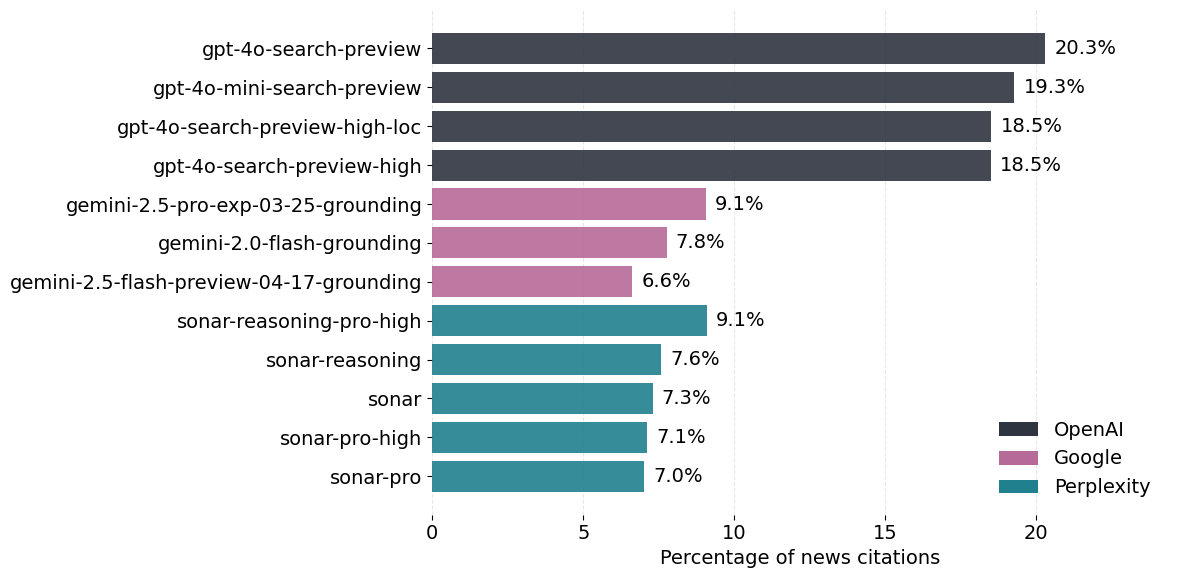

In [13]:
# Create horizontal bar plot for news citation percentages by model
fig, ax = plt.subplots(figsize=(12, 6))


# Add provider information for better organization
model_stats_df["provider"] = model_stats_df["model"].apply(get_model_provider)


colors = [provider_colors[provider] for provider in model_stats_df["provider"]]

# Create horizontal bar plot
bars = ax.barh(
    range(len(model_stats_df)),
    model_stats_df["news_percentage"],
    color=colors,
    alpha=0.9,
)

# Customize the plot
ax.set_xlabel("Percentage of news citations")

# Set y-axis labels
ax.set_yticks(range(len(model_stats_df)))
ax.set_yticklabels(model_stats_df["model"])

# Add percentage labels at the end of bars
for i, (bar, row) in enumerate(zip(bars, model_stats_df.itertuples())):
    ax.text(
        bar.get_width() + 0.3,
        bar.get_y() + bar.get_height() / 2,
        f"{row.news_percentage:.1f}%",
        ha="left",
        va="center",
    )

# Add grid for better readability
ax.grid(True, axis="x", alpha=0.3, linestyle="--")
ax.set_axisbelow(True)

# Set x-axis to start from 0 and add some padding
ax.set_xlim(0, max(model_stats_df["news_percentage"]) * 1.2)

# Improve overall appearance
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Add legend for providers
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=color, label=provider_names.get(provider))
    for provider, color in provider_colors.items()
    if provider in model_stats_df["provider"].values
]
ax.legend(handles=legend_elements, loc="lower right", frameon=False)

# Adjust layout
plt.tight_layout()

# Not included in the final paper
#plt.savefig("../../data/output/cleaned_arena_data/model_news_citation_rates.pdf")